In [2]:
!unzip fashion-mnist.zip

Se truncaron las últimas líneas 5000 del resultado de transmisión.
  inflating: fashion-mnist/test/0/2423.png  
  inflating: fashion-mnist/test/0/444.png  
  inflating: fashion-mnist/test/0/965.png  
  inflating: fashion-mnist/test/0/1460.png  
  inflating: fashion-mnist/test/0/3440.png  
  inflating: fashion-mnist/test/0/2795.png  
  inflating: fashion-mnist/test/0/2474.png  
  inflating: fashion-mnist/test/0/169.png  
  inflating: fashion-mnist/test/0/1647.png  
  inflating: fashion-mnist/test/0/2121.png  
  inflating: fashion-mnist/test/0/2163.png  
  inflating: fashion-mnist/test/0/2753.png  
  inflating: fashion-mnist/test/0/645.png  
  inflating: fashion-mnist/test/0/34.png  
  inflating: fashion-mnist/test/0/716.png  
  inflating: fashion-mnist/test/0/3874.png  
  inflating: fashion-mnist/test/0/3128.png  
  inflating: fashion-mnist/test/0/2180.png  
  inflating: fashion-mnist/test/0/2439.png  
  inflating: fashion-mnist/test/0/269.png  
  inflating: fashion-mnist/test/0/2027.pn

In [20]:
from glob import glob

train_files = glob('./fashion-mnist/train/*/*.png')
valid_files = glob('./fashion-mnist/valid/*/*.png')
test_files = glob('./fashion-mnist/test/*/*.png')

train_files[0]

'./fashion-mnist/train/8/45081.png'

In [21]:
import numpy as np

np.random.shuffle(train_files)
np.random.shuffle(valid_files)
np.random.shuffle(test_files)

len(train_files), len(valid_files), len(test_files)

(55000, 10000, 5000)

In [22]:
from PIL import Image

N_train = len(train_files)
X_train = []
Y_train = []

for i, train_file in enumerate(train_files):
  Y_train.append( int(train_file.split('/')[3]) )
  X_train.append(np.array(Image.open(train_file)))

In [23]:
N_valid = len(valid_files)
X_valid = []
Y_valid = []

for i, valid_file in enumerate(valid_files):
  Y_valid.append( int(valid_file.split('/')[3]) )
  X_valid.append( np.array(Image.open(valid_file)) )

In [24]:
N_test = len(test_files)
X_test = []
Y_test = []

for i, test_file in enumerate(test_files):
  Y_test.append( int(test_file.split('/')[3]) )
  X_test.append( np.array(Image.open(test_file)) )

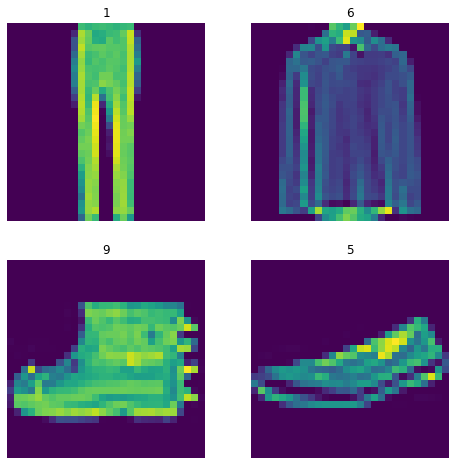

In [25]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8,8))
for i in range(4):
  plt.subplot(2,2,i+1)
  plt.imshow(X_test[i*15])
  plt.title(Y_test[i*15])
  plt.axis(False)
plt.show()

In [26]:
import torch
from torch.autograd import Variable


X_train = Variable(torch.from_numpy(np.array(X_train))).float()
Y_train = Variable(torch.from_numpy(np.array(Y_train))).long()

X_valid = Variable(torch.from_numpy(np.array(X_valid))).float()
Y_valid = Variable(torch.from_numpy(np.array(Y_valid))).long()

X_test = Variable(torch.from_numpy(np.array(X_test))).float()
Y_test = Variable(torch.from_numpy(np.array(Y_test))).long()

X_train.data.size()

torch.Size([55000, 28, 28])

In [27]:
import torch

batch_size = 288

train_ds = torch.utils.data.TensorDataset(X_train, Y_train)
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)


cuda:0


In [28]:
model = torch.nn.Sequential(
  torch.nn.Conv2d(1, 16, kernel_size=4, stride=1, padding=2),
  torch.nn.ReLU(),
  torch.nn.MaxPool2d(kernel_size=2),
  torch.nn.Dropout(p=0.1),
  torch.nn.Conv2d(16, 32, kernel_size=4, stride=1, padding=2),
  torch.nn.ReLU(),
  torch.nn.MaxPool2d(kernel_size=2),
  torch.nn.Dropout(p=0.1), 
  torch.nn.Flatten(),
  torch.nn.Linear(7*7*32, 10),
)
model

Sequential(
  (0): Conv2d(1, 16, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Dropout(p=0.1, inplace=False)
  (4): Conv2d(16, 32, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
  (5): ReLU()
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.1, inplace=False)
  (8): Flatten(start_dim=1, end_dim=-1)
  (9): Linear(in_features=1568, out_features=10, bias=True)
)

In [29]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001, weight_decay=0.1)

In [30]:
!pip install hiddenlayer

/usr/local/lib/python3.7/dist-packages/torch/onnx/symbolic_helper.py:715: UserWarning: ONNX export mode is set to inference mode, but operator dropout is set to training  mode. The model will be exported in inference, as specified by the export mode.
  training_mode + ", as specified by the export mode.")


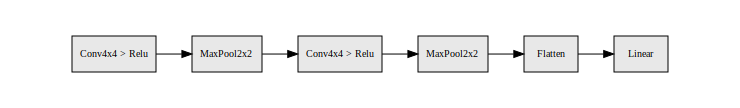

In [31]:
import hiddenlayer as hl

hl.build_graph(model, torch.zeros([32,1,28,28]))

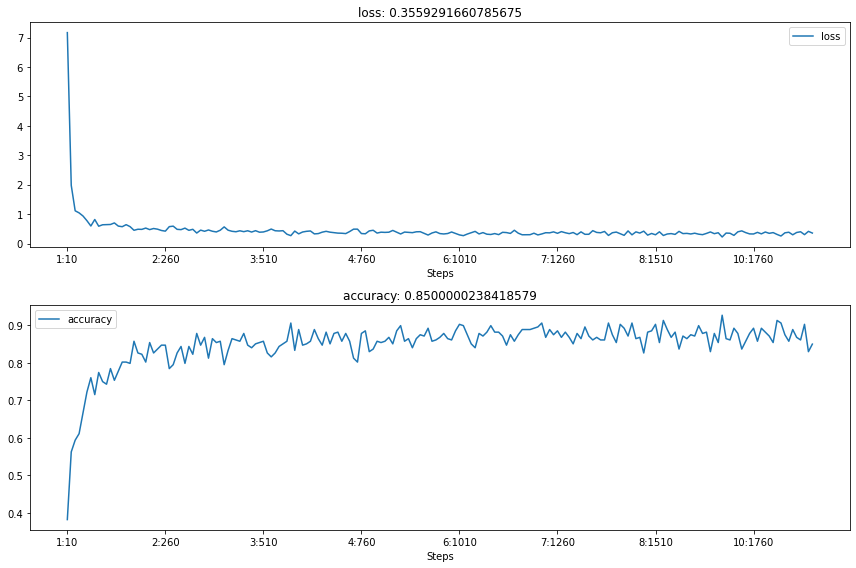

In [32]:
from sklearn.metrics import f1_score

n_epoch = 10

history = hl.History()
canvas = hl.Canvas()

iter = 0

for epoch in range(n_epoch):
  for batch_id, (X_train_batch, Y_train_batch) in enumerate(train_dl):
    model.train()
    #print(X_train_batch.size())
    Xtr = X_train_batch.unsqueeze(1)
    #print(Xtr.size())
    Y_pred = model(Xtr)

    loss = criterion(Y_pred,Y_train_batch)

    Y_pred = torch.argmax(Y_pred, 1)
    f1 = f1_score(Y_train_batch, Y_pred, average='macro')    

    acc = sum(Y_train_batch == Y_pred)/len(Y_pred)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    iter += 1

    if iter%10 == 0:
        #-- Visualizamos la evolución de los score loss y accuracy
        history.log((epoch+1, iter), loss=loss, accuracy=acc,f1=f1)
        with canvas:
          canvas.draw_plot(history["loss"])
          canvas.draw_plot(history["accuracy"])
          canvas.draw_plot(history["f1"])

In [33]:
model.eval()
Xvl = X_valid.unsqueeze(1)
Y_pred = model(Xvl)  
loss = criterion(Y_pred,Y_valid)

Y_pred = torch.argmax(Y_pred, 1)
f1 = f1_score(Y_valid, Y_pred, average='macro')

acc = sum(Y_valid == Y_pred)/len(Y_pred)

print( 'Loss:{:.2f}, F1:{:.2f}, Acc:{:.2f}'.format(loss.item(), f1, acc ) )

Loss:0.33, F1:0.88, Acc:0.88


In [34]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [45]:
model = torch.nn.Sequential(
  torch.nn.Conv2d(1, 16, kernel_size=4, stride=1, padding=2),
  torch.nn.ReLU(),
  torch.nn.MaxPool2d(kernel_size=2),
  torch.nn.Dropout(p=0.1),
  torch.nn.Conv2d(16, 32, kernel_size=4, stride=1, padding=2),
  torch.nn.ReLU(),
  torch.nn.MaxPool2d(kernel_size=2),
  torch.nn.Dropout(p=0.1), 
  torch.nn.Flatten(),
  torch.nn.Linear(7*7*32, 10),
)
model

Sequential(
  (0): Conv2d(1, 16, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Dropout(p=0.1, inplace=False)
  (4): Conv2d(16, 32, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
  (5): ReLU()
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.1, inplace=False)
  (8): Flatten(start_dim=1, end_dim=-1)
  (9): Linear(in_features=1568, out_features=10, bias=True)
)

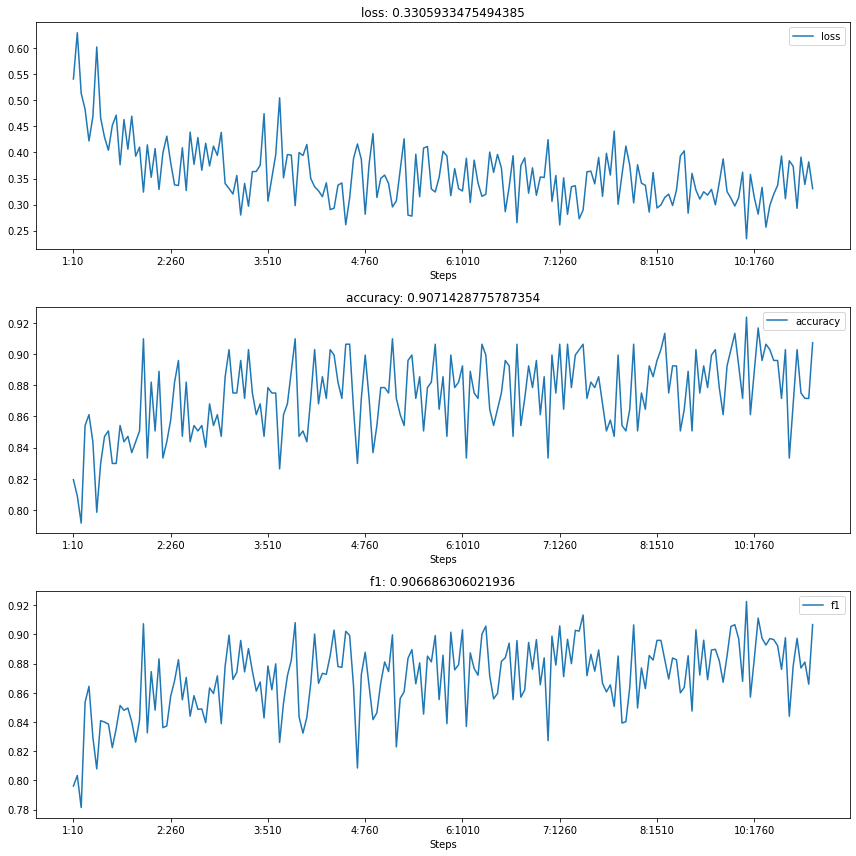

In [47]:
model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001, weight_decay=0.1)

n_epoch = 10

history2 = hl.History()
canvas2 = hl.Canvas()

iter = 0

for epoch in range(n_epoch):
  for batch_id, (X_train_batch, Y_train_batch) in enumerate(train_dl):

    #-- Cargamos los datos en la GPU
    X_train_batch, Y_train_batch = X_train_batch.to(device), Y_train_batch.to(device)

    model.train()
    Xtr = X_train_batch.unsqueeze(1)
    Y_pred = model(Xtr)

    loss = criterion(Y_pred,Y_train_batch)

    Y_pred = torch.argmax(Y_pred, 1)

    #-- Calculamos el f1 en la cpu
    f1 = f1_score(Y_train_batch.cpu(),Y_pred.cpu(), average='macro')

    acc = sum(Y_train_batch == Y_pred)/len(Y_pred)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    iter += 1

    if iter%10 == 0:
        history2.log((epoch+1, iter), loss=loss, accuracy=acc,f1=f1)
        with canvas2:
          canvas2.draw_plot(history2["loss"])
          canvas2.draw_plot(history2["accuracy"])
          canvas2.draw_plot(history2["f1"])

In [48]:
X_valid, Y_valid = X_valid.to(device), Y_valid.to(device)
model.eval()
Xvl = X_valid.unsqueeze(1)
Y_pred = model(Xvl)  
loss = criterion(Y_pred,Y_valid)

Y_pred = torch.argmax(Y_pred, 1)
f1 = f1_score(Y_valid.cpu(), Y_pred.cpu(), average='macro')

acc = sum(Y_valid == Y_pred)/len(Y_pred)

print( 'Loss:{:.2f}, F1:{:.2f}, Acc:{:.2f}'.format(loss.item(), f1, acc ) )

Loss:0.32, F1:0.89, Acc:0.89


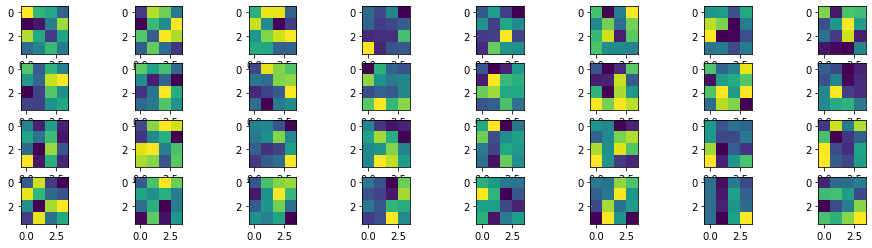

In [38]:
kernels = list(model.children())[4].weight.detach()
kernels = kernels.cpu()
fig = plt.figure(figsize=(16,4))
k = 0
for i in range(kernels.size(0)):
    plt.subplot(4,8,k+1)
    plt.imshow(kernels[i][1])
    k += 1

plt.show()

In [39]:
from sklearn.metrics import confusion_matrix

def CM(Y_true, Y_pred, classes):
  fig = plt.figure(figsize=(10, 10))
  cm = confusion_matrix(Y_true, Y_pred)
  lclasses = np.arange(0,classes)
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
  cmap=plt.cm.Blues
  ax = fig.add_subplot(1,1,1)
  im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
  ax.figure.colorbar(im, ax=ax, pad=0.01, shrink=0.86)
  ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]),xticklabels=lclasses, yticklabels=lclasses)
  ax.set_xlabel("Predicted",size=20)
  ax.set_ylabel("True",size=20)
  ax.set_ylim(classes-0.5, -0.5)

  plt.setp(ax.get_xticklabels(), size=12)
  plt.setp(ax.get_yticklabels(), size=12)

  fmt = '.2f'
  thresh = cm.max()/2.
  for i in range(cm.shape[0]):
      for j in range(cm.shape[1]):
          ax.text(j, i, format(cm[i, j], fmt),ha="center", va="center",size=15 , color="white" if cm[i, j] > thresh else "black")

  plt.show()

In [49]:
X_test, Y_test = X_test.to(device), Y_test.to(device)
model.eval()
Xvl = X_test.unsqueeze(1)
Y_pred = model(Xvl)  
loss = criterion(Y_pred,Y_test)

Y_pred = torch.argmax(Y_pred, 1)
f1 = f1_score(Y_test.cpu(), Y_pred.cpu(), average='macro')

acc = sum(Y_test == Y_pred)/len(Y_pred)

print( 'Loss:{:.2f}, F1:{:.2f}, Acc:{:.2f}'.format(loss.item(), f1, acc ) )

Loss:0.30, F1:0.90, Acc:0.90


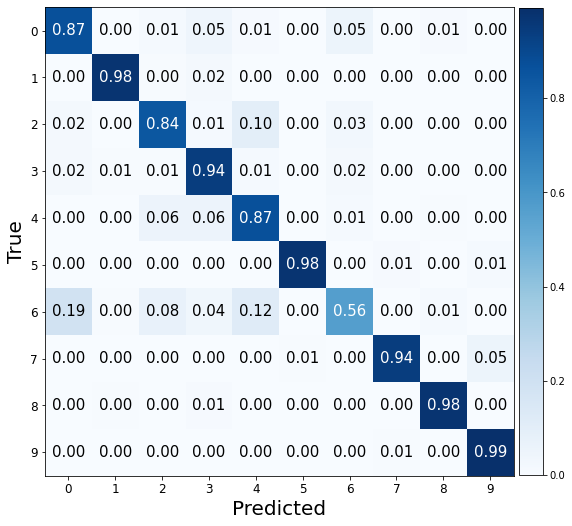

In [41]:
CM(Y_test.cpu(), Y_pred.cpu(), 10)

Para este modelo se utilizaron 10 capas,las caracteristicas de la primera son 1 y 16 y para la segunda son 16 y 32 similares al modelo que trabajamos en clase, para el f1 y el accuracy con los datos de testeo se obtuvo un valor de 0.9 lo cual está bastante bien, pero fue difícil llegar a este valor, por otra parte la matriz de confusión tuvo resultados bastante buenos en la mayoría de los casos excepto en el 6, donde hay una confusión evidente, pero de todas las combinaciones que logré hacer me parecio más prudente dejar a los otros con valores altos y uno solo no tan bueno